# Required Libraries

Using `pandas` to read and process tabular data and `missingno` to visualize missing data.

In [1]:
from data import load_data

# loading FISH makers, gene expressions
_, fish, genes, _, _ = load_data()

fish.head()

,13q14,13q34,17p13,1q21,11p15,15q15,19q13,20q13,21q22,3q21,...,9q33,t_11_14_ccnd1,t_12_14_ccnd2,t_14_16_maf,t_14_20_mafb,t_4_14_whsc1,t_6_14_ccnd3,t_8_14_mafa,t_8_14_myc,hyperdiploid_flag
ID,,,,,,,,,,,,,,,,,,,,,
MMRF1021,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MMRF1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MMRF1029,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MMRF1030,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
MMRF1031,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Filtering Fish Variables

Below in fit models to estimate fish variables from gene counts. We consider X fish variables: 13q14, 13q34, 17p13, 1q21, 11p15, 15q15, 19q13, 20q13, 21q22, 3q21, 5q31, 7q22, 9q33, t_11_14_ccnd1, t_12_14_ccnd2, t_14_16_maf, t_14_20_mafb, t_4_14_whsc1, t_6_14_ccnd3, t_8_14_mafa, t_8_14_myc, and hyperdiploid_flag.

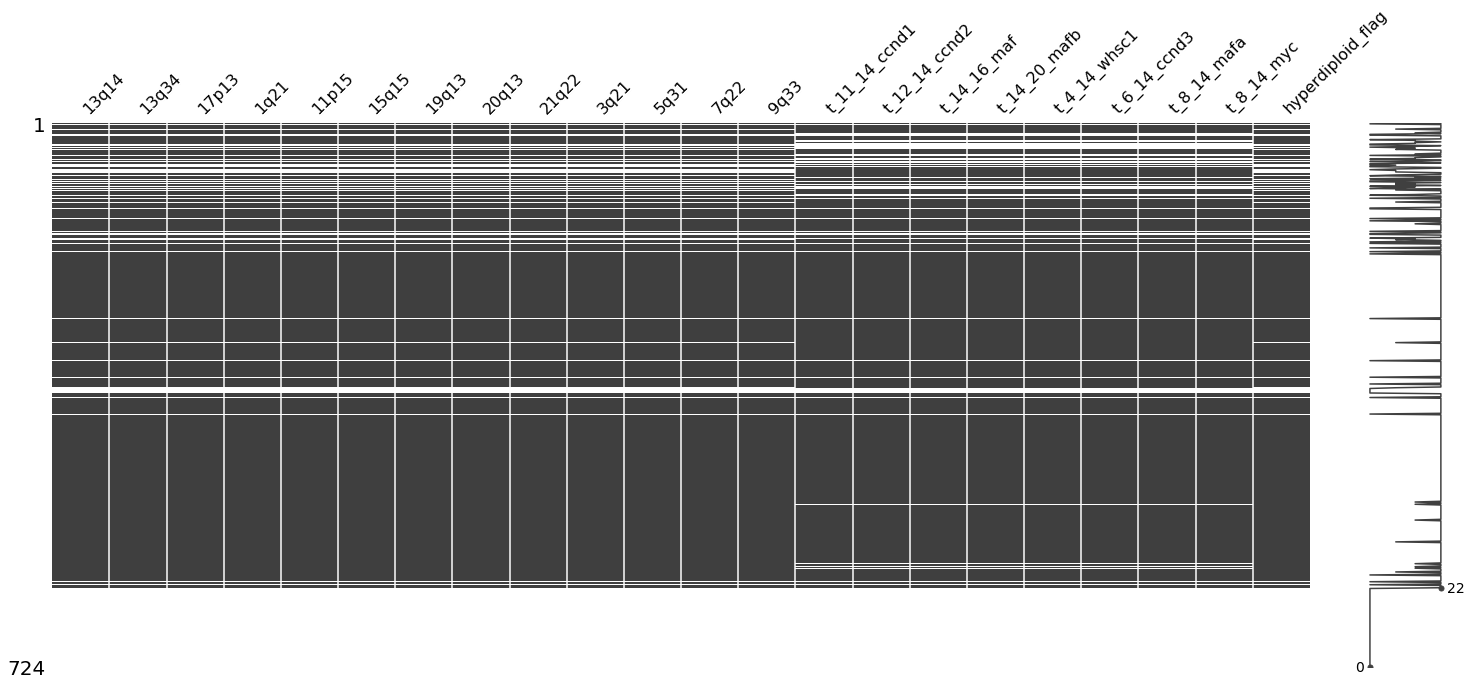

In [2]:
%matplotlib inline

import numpy as np
import missingno as msn

msn.matrix(fish);

# Fitting Models and Complete Missing Values

In [25]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

from correlation import select_genes
from evaluation import optimize_threshold
from constants import N_FOLDS, RANDOM_STATE

from optimization import LightGBMOptimizer

from lightgbm import LGBMModel

import pandas as pd
import pickle
import time
import os

result = {c: [] for c in ['experiment', 'marker', 'train_auc', 'valid_auc', 'train_loss', 'valid_loss', 'execution_time']}

# removing fish markers with less than
# five samples in class 1

for m in ['t_12_14_ccnd2', 't_14_20_mafb', 't_6_14_ccnd3', 't_8_14_mafa']:
    if m in fish:
        del fish[m]

for t in fish.columns:
    
    print('*********************************************************************************')
    print(t)
    print('*********************************************************************************\n')
    
    y = fish[t].dropna()
    
    x = genes.join(y, how='inner')[genes.columns]
    
    opt_kf = StratifiedKFold(N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    for experiment, (opt_train, opt_valid) in enumerate(opt_kf.split(x, y)):
        
        initial_time = time.time()
        
        #################################################################################################
        # Train and Valid Split
        #################################################################################################
        
        x_train, y_train = x.iloc[opt_train,:], y.iloc[opt_train]
        
        x_valid, y_valid = x.iloc[opt_valid,:], y.iloc[opt_valid]

        #################################################################################################
        # Gene Selection
        #################################################################################################
        
        selected_genes = select_genes(x_train, y_train, threshold=0.00002)
        
        x_train, x_valid = x_train[selected_genes[0]], x_valid[selected_genes[0]]
        
        #################################################################################################
        # Export selected genes
        #################################################################################################
        
        filepath = './output/fish/{}/selected_genes_experiment_{}.csv'.format(t, experiment)
        try:
            os.makedirs(os.path.dirname(os.path.abspath(filepath)))
        except FileExistsError:
            pass
        
        df = pd.DataFrame({'gene': selected_genes[0], 'pvalue': selected_genes[1], 'entropy': selected_genes[2]})
        
        df.to_csv(filepath, sep=',', index=False)
        
        del df
        
        del filepath
        
        #################################################################################################
        # Hyper parameters optimization
        #################################################################################################        
        
        training_default_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'n_estimators': 100,
            'objective': 'binary',
            'is_unbalance': False, 
            'extra_trees': True,
            'max_depth': 4,
            'learning_rate': 0.1,
            'min_split_gain': 0.0001,
            'min_child_weight': 0.0001,
            'random_state': RANDOM_STATE}
        
        optimizer_params = {
            'n_folds': 2, 
            'n_calls': 50, 
            'shuffle': True, 
            'early_stopping_rounds': 1,
            'fixed_parameters': training_default_params, 
            'random_state': RANDOM_STATE, 
            'use_gpu': False}
        
        optimizer = LightGBMOptimizer(**optimizer_params)
        
        params = optimizer.optimize(x_train, y_train)

        params = {**params, **training_default_params}
        
        skf = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)

        models = []
        
        for train_index, valid_index in skf.split(x_train, y_train):

            xx_train, yy_train = x_train.values[train_index, :], y_train.values[train_index]
            xx_valid, yy_valid = x_train.values[valid_index, :], y_train.values[valid_index]

            gbm = LGBMModel(**params)

            gbm.fit(xx_train, yy_train,
                    eval_set=[(xx_valid, yy_valid)],
                    early_stopping_rounds=1,
                    verbose=False)
            
            models.append(gbm)
        
        #################################################################################################
        # Predicting
        #################################################################################################        
        
        y_hat_train, y_hat_valid = None, None
        
        for model in models:
            
            y_ = model.predict(x_train)
            y_hat_train = y_ if y_hat_train is None else y_ + y_hat_train
            
            y_ = model.predict(x_valid)
            y_hat_valid = y_ if y_hat_valid is None else y_ + y_hat_valid
        
        y_hat_train /= len(models)
        y_hat_valid /= len(models)
        
        train_auc = roc_auc_score(y_train, y_hat_train)
        valid_auc = roc_auc_score(y_valid, y_hat_valid)
        
        train_loss = log_loss(y_train, y_hat_train)
        valid_loss = log_loss(y_valid, y_hat_valid)
        
        result['experiment'].append(experiment)
        result['marker'].append(t)
        result['train_auc'].append(train_auc)
        result['valid_auc'].append(valid_auc)
        result['train_loss'].append(train_loss)
        result['valid_loss'].append(valid_loss)
        result['execution_time'].append(time.time() - initial_time)
        
        log_message = 'Experiment #{}: '.format(experiment) + 'Train AUC: {}'.format(train_auc) + ' '
        log_message += 'Valid AUC: {}'.format(valid_auc)
        
        print(log_message)
        
result = pd.DataFrame(result)

result.head()
        

*********************************************************************************
13q14
*********************************************************************************

3139
Experiment #0: Train AUC: 0.9995373124462952 Valid AUC: 0.9948979591836735
3797
Experiment #1: Train AUC: 0.9924648026968075 Valid AUC: 0.9387755102040817
3303
Experiment #2: Train AUC: 0.9938032916914535 Valid AUC: 0.9910714285714286
4346
Experiment #3: Train AUC: 0.9966289906801507 Valid AUC: 0.9413265306122449
3590
Experiment #4: Train AUC: 0.9992624039076202 Valid AUC: 0.9711934156378601
3764
Experiment #5: Train AUC: 0.9985575898637906 Valid AUC: 0.9657064471879286
3796
Experiment #6: Train AUC: 0.9954760773000705 Valid AUC: 0.9725651577503429
3962
Experiment #7: Train AUC: 0.9977544296743104 Valid AUC: 0.9561042524005486
3708
Experiment #8: Train AUC: 0.9955252503728957 Valid AUC: 0.9465020576131686
4040
Experiment #9: Train AUC: 0.9985575898637906 Valid AUC: 0.9657064471879288
*****************************

,experiment,marker,train_auc,valid_auc,train_loss,valid_loss,execution_time
0,0,13q14,0.999537,0.994898,0.140998,0.169025,128.495195
1,1,13q14,0.992465,0.938776,0.238901,0.364554,159.501240
2,2,13q14,0.993803,0.991071,0.213371,0.211641,140.205988
3,3,13q14,0.996629,0.941327,0.178572,0.346800,166.490632
4,4,13q14,0.999262,0.971193,0.145448,0.238230,155.517009


In [26]:
result.to_csv('output/fish/metrics.csv', sep=',', index=False)

result.groupby('marker').mean()

,experiment,train_auc,valid_auc,train_loss,valid_loss,execution_time
marker,,,,,,
11p15,4.5,0.992090,0.941706,0.201196,0.314489,177.994305
13q14,4.5,0.996757,0.964385,0.174299,0.266534,155.772878
13q34,4.5,0.996466,0.968804,0.162149,0.249699,139.525720
15q15,4.5,0.998006,0.978676,0.141841,0.231111,249.539648
17p13,4.5,0.951845,0.819792,0.224822,0.304181,100.756751
19q13,4.5,0.993926,0.962629,0.188694,0.279827,232.981740
1q21,4.5,0.996959,0.962723,0.183808,0.280748,133.891432
20q13,4.5,0.981682,0.800411,0.110715,0.171896,95.021663
21q22,4.5,0.998333,0.971563,0.177150,0.257597,117.547999


In [5]:
result.groupby('marker').mean().mean()

experiment          4.500000
train_auc           0.990698
valid_auc           0.945316
train_loss          0.157585
valid_loss          0.235992
execution_time    172.523410
dtype: float64

In [7]:
result.groupby('marker').mean().min()

experiment         4.500000
train_auc          0.951845
valid_auc          0.800411
train_loss         0.013149
valid_loss         0.027579
execution_time    95.021663
dtype: float64

In [6]:
result.groupby('marker').mean().std()

experiment         0.000000
train_auc          0.014681
valid_auc          0.059178
train_loss         0.068391
valid_loss         0.094608
execution_time    54.524014
dtype: float64

In [4]:
result.groupby('marker').std()

,experiment,train_auc,valid_auc,train_loss,valid_loss,execution_time
marker,,,,,,
11p15,3.02765,0.004691,0.034178,0.030011,0.058327,5.784054
13q14,3.02765,0.002399,0.019252,0.032391,0.059887,12.607887
13q34,3.02765,0.002533,0.029907,0.029471,0.068428,14.093981
15q15,3.02765,0.001951,0.012460,0.036173,0.032185,14.100453
17p13,3.02765,0.016943,0.069757,0.024931,0.031981,5.879968
19q13,3.02765,0.003738,0.023965,0.026558,0.059706,7.681591
1q21,3.02765,0.003274,0.018732,0.028873,0.040930,3.316295
20q13,3.02765,0.009669,0.101193,0.012458,0.022945,6.053089
21q22,3.02765,0.001110,0.028138,0.034252,0.051345,3.005401
